# OpenET Pilot Study Workflow Example

Presented at TPS GIS Roundtable Meeting 2/20/25 by Hannah Haugen


In [1]:
# Initial setup (more packages will be loaded at relevant steps)
import os

# Chane directory to allow imports internal to the project
os.chdir('C:/Users/CND571/PycharmProjects/openet')

# All data for this example will be saved to this directory:
main_dir = 'C:/Users/CND571/PycharmProjects/openet/examples'

In [2]:
# Load sample fields
import geopandas as gpd

fields = gpd.read_file(os.path.join(main_dir, 'gc12.shp'))
# fields.head()

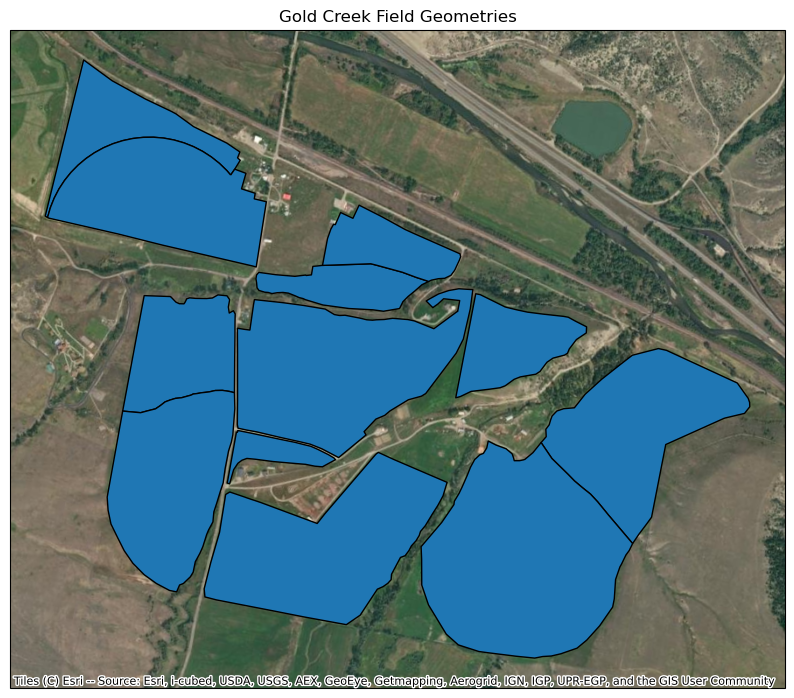

In [3]:
# Visualize sample fields

import matplotlib.pyplot as plt
import contextily as ctx
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.epsg(5071)})
fields.plot(ax=ax, edgecolor='black', transform=ccrs.epsg(5071))
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=ccrs.epsg(5071))
plt.title('Gold Creek Field Geometries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## **API #1** - Google Earth Engine (GEE)

This API is used to get Irrmapper data, which is a yearly categorization of land as being irrigated or not. When averaged over a field, it estimates the percentage of the field that was irrigated in a given year. (Or is it the probability that the field was irrigated?)

When working with the GEE API, I often find it helpful to practice the operations in the interactive GEE code editor, so I can check the intermediate processing steps before exporting data (https://code.earthengine.google.com/). The thing to note here is that the editor is in JavaScript, so the translation between programming languages may make this process more annoying.

In order to export spatially averaged information over the example fields, we need to first manually upload the shapefile shown above to GEE. Then we can proceed with the code below.

In [4]:
# Initialize connection to GEE

import ee
from from_swim_rs.etf_export import is_authorized

if not is_authorized():
    ee.Authenticate()
ee.Initialize()

Authorized


In [5]:
# Get irrmapper data from gee

# from from_swim_rs.etf_export import irrmapper_export  # function that this code is based on

irr = 'projects/ee-dgketchum/assets/IrrMapper/IrrMapperComp'  # Path to Irrmapper dataset on GEE
gee_fields = 'projects/ee-hehaugen/assets/gc12'  # Path to asset/shapefile on GEE

bucket = 'mt_cu_2024'  # Google Cloud Storage bucket to export data to
im_filename='irrmapper_ref_gc12'  # filename for exported data

start_yr, end_yr = 2016, 2024

# Load the field shapefile
feature_coll = ee.FeatureCollection(gee_fields)

# Processing
first_year_img = ee.Image(irr + '/MT_{}'.format(start_yr)).lt(1).rename(str(start_yr))
for yr in range(start_yr, end_yr + 1):
    year_img = ee.Image(irr + '/MT_{}'.format(yr)).lt(1).rename(str(yr))
    first_year_img = first_year_img.addBands(year_img)
result = first_year_img.reduceRegions(feature_coll, ee.Reducer.mean())

# Export
task = ee.batch.Export.table.toDrive(
    collection=result, 
    description=im_filename
    )
task.start()

In [6]:
## Look at the file after it's been downloaded from Google Drive

import pandas as pd

im_data = pd.read_csv(os.path.join(main_dir, '{}.csv'.format(im_filename)))
im_data.head()

,system:index,2016,2016_1,2017,2018,2019,2020,2021,2022,2023,2024,COUNTYNAME,COUNTY_NO,FID,ITYPE,MAPPEDBY,SOURCECODE,USAGE,.geo
0,00000000000000000000,0.777127,0.777127,0.918771,0.946443,0.930256,0.941325,0.925236,0.931921,0.929325,0.935227,Powell,77,077_000017,F,KH,MTDNRC,3,"{""type"":""Polygon"",""coordinates"":[[[-112.933375..."
1,00000000000000000001,0.251342,0.251342,0.200805,0.428332,0.229316,0.260174,0.203153,0.146355,0.807469,0.043493,Powell,77,077_000018,F,KH,MTDNRC,3,"{""type"":""Polygon"",""coordinates"":[[[-112.927720..."
2,00000000000000000002,0.875898,0.875898,0.871855,0.886257,0.880041,0.892104,0.896448,0.877335,0.890868,0.672102,Powell,77,077_000019,F,KH,MTDNRC,3,"{""type"":""Polygon"",""coordinates"":[[[-112.917468..."
3,00000000000000000003,0.154993,0.154993,0.235277,0.258052,0.294502,0.294502,0.279588,0.215599,0.304460,0.120593,Powell,77,077_000020,F,KH,MTDNRC,3,"{""type"":""Polygon"",""coordinates"":[[[-112.928110..."
4,0000000000000000000a,0.648112,0.648112,0.892317,0.913520,0.905220,0.892266,0.882195,0.706485,0.942869,0.765184,Powell,77,077_000063,F,KH,MTDNRC,3,"{""type"":""Polygon"",""coordinates"":[[[-112.927744..."


## **API #2** - OpenET

This API is used to access ETof data, or the observed fraction of the daily grass reference evapotranspiration value at each location. The raster data is averaged over the footprint of each field to get a single value for each polygon.

OpenET API reference: https://openet.gitbook.io/docs

Interactive data visualization: https://explore.etdata.org/#5/39.665/-110.396

Access to the OpenET data is routed partially through Google Earth Engine, even though the API is separate, so we need to link our GEE account to our OpenET account to reference the shapefile stored there. This function will export the data to Google Drive, which will then be downloaded manually.

In [7]:
# Get openet data

from run.opnt import openet_get_fields_export  # function this code is based on

import requests

start, end = "2016-01-01", "2023-12-31"
api_key='C:/Users/CND571/Documents/Haugen_Montana_API.txt'

# set your API key before making the request
with open(api_key, 'r') as f:
    api_key = f.readline()

header = {"Authorization": api_key}

# endpoint arguments
args = {
    "date_range": [
        start,
        end
    ],
    "interval": "monthly",
    "asset_id": gee_fields,
    "attributes": [
        "FID"
    ],
    "reducer": "mean",
    "model": "Ensemble",
    "variable": "ETof",
    "reference_et": "gridMET",
    "units": "in"
}

# query the api
resp = requests.post(
    headers=header,
    json=args,
    url="https://openet-api-montana-ic5gyecbva-uw.a.run.app/raster/export/multipolygon"
)
print(resp.json())

{'tracking_id': 'M2VI4C64ST56YG3LHBPAYQH7', 'encrypted': False, 'name': 'f3b50', 'destination': 'drive'}


In [8]:
## Look at the file after it's been downloaded from Google Drive
et_data = pd.read_csv(os.path.join(main_dir, 'etof_files', 'ensemble_etof_gc12.csv'))
et_data.head()

,time,FID,etof,acres
0,2016-01-01,077_000017,0.0,35.512
1,2016-01-01,077_000018,0.0,7.790
2,2016-01-01,077_000019,0.0,26.043
3,2016-01-01,077_000020,0.0,18.267
4,2016-01-01,077_000063,0.0,85.433


### Database Work

Because of the ultimate scale of the project (comparing methods of consumptive use calculations across all 52,000 fields in the Statewide Irrgiation Dataset), all of the data and results we gather will be stored in a SQLite database.

In [9]:
import sqlite3
from run.run_all import *

# Open/Create new database
conec = sqlite3.connect(os.path.join(main_dir, "opnt_analysis_example1.db"))

# Initialize tables with correct column names/types/primary keys
init_db_tables(conec)

# sqlite database table names created in function above
gm_ts, fields_db, results, etof_db = 'gridmet_ts', 'field_data', 'field_cu_results', 'opnt_etof'
irr_db, iwr_cu_db = 'irrmapper', 'static_iwr_results'

In [10]:
# update irrmapper table with data from above
im_filepath = os.path.join(main_dir, '{}.csv'.format(im_filename))  # location of downloaded Irrmapper data
update_irrmapper_table(conec, im_filepath)

# view table structure
pd.read_sql("SELECT * FROM {} LIMIT 5".format(irr_db), conec)

,fid,year,frac_irr
0,077_000017,2016,0.777127
1,077_000017,2016_1,0.777127
2,077_000017,2017,0.918771
3,077_000017,2018,0.946443
4,077_000017,2019,0.930256


In [11]:
# update etof table using openet data from above
etof_loc = os.path.join(main_dir, 'etof_files')  # location of downloaded OpenET data
update_etof_db_1(conec, etof_loc, etof_db)

# view table structure
pd.read_sql("SELECT * FROM {} LIMIT 5".format(etof_db), conec)

Updating etof table with new county data


100%|██████████| 1/1 [00:00<00:00, 137.75it/s]

,time,fid,etof,acres
0,2016-01-01,077_000017,0.0,35.512
1,2016-01-01,077_000018,0.0,7.790
2,2016-01-01,077_000019,0.0,26.043
3,2016-01-01,077_000020,0.0,18.267
4,2016-01-01,077_000063,0.0,85.433


## **API #3** - THREDDS

This API is used to access GridMET gridded meteorological data. We are primarily accessing it for the value of grass reference evapotranspiration.

With this API, we are able to download the data directly into memory, and then process and save it to the database file without intermediate files or steps.

For the underlying code to access GridMET through the THREDDS server: https://github.com/MTDNRC-WRD/chmdata

For more information on the dataset: https://www.climatologylab.org/gridmet.html

In [12]:
# location of gridmet files
gm_d = 'F:/openet_pilot/gridmet'
gridmet_cent = os.path.join(gm_d, 'gridmet_centroids_MT.shp')  # Shapefile with gridmet cell centroid locations
rasters_ = os.path.join(gm_d, 'correction_surfaces_aea')  # Correction surfaces, one for each month and variable

# Populate fid/gridmet lookup db table (about 7 hours?)
gridmet_match_db(conec, fields, gridmet_cent, fields_db)

# view table structure
pd.read_sql("SELECT * FROM {} LIMIT 5".format(fields_db), conec)

Finding field-gridmet joins for 12 fields
Found 2 gridmet target points for 12 new fields



,fid,itype,usage,mapped_by,county,gfid,lat,lon,elev_gm
0,077_000017,F,3,KH,None,94533,46.578771,-112.931090,1347.280029
1,077_000018,F,3,KH,None,94533,46.575985,-112.925717,1347.280029
2,077_000019,F,3,KH,None,94533,46.580974,-112.915267,1347.280029
3,077_000020,F,3,KH,None,94533,46.581929,-112.923711,1347.280029
4,077_000038,P,3,KH,None,94533,46.573139,-112.922587,1347.280029


In [13]:
# define period of study for gridmet fetching
pos_start, pos_end = '2016-01-01', '2023-12-31'

# Populate gridmet db table (also fetches data from gridmet - change to the xvec extraction method?)
corrected_gridmet_db_1(conec, gridmet_cent, fields_db, gm_ts, rasters_, pos_start, pos_end)

# view table structure
pd.read_sql("SELECT * FROM {} LIMIT 5".format(gm_ts), conec)

Looking for missing data...
Loading correction factors...


c:\Users\CND571\.conda\envs\mihm_3\Lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


Get gridmet for 2 target points


100%|██████████| 2/2 [00:22<00:00, 11.05s/it]

,gfid,date,year,month,day,centroid_lat,centroid_lon,elev_m,tmin_c,tmax_c,prcp_mm,etr_mm,eto_mm,etr_mm_uncorr,eto_mm_uncorr,q_kgkg,srad_wm2,u10_ms,wdir_deg,vpd_kpa
0,94533,2016-01-01,2016,1,1,46.567,-112.933,1347.280029,-23.849991,-8.850006,0.0,0.659525,0.380491,0.7,0.4,None,None,None,None,None
1,94533,2016-01-02,2016,1,2,46.567,-112.933,1347.280029,-23.549988,-4.949982,0.0,0.847960,0.475614,0.9,0.5,None,None,None,None,None
2,94533,2016-01-03,2016,1,3,46.567,-112.933,1347.280029,-20.049988,-3.750000,0.9,0.659525,0.380491,0.7,0.4,None,None,None,None,None
3,94533,2016-01-04,2016,1,4,46.567,-112.933,1347.280029,-12.350006,2.149994,0.0,0.942178,0.570737,1.0,0.6,None,None,None,None,None
4,94533,2016-01-05,2016,1,5,46.567,-112.933,1347.280029,-10.750000,4.350006,0.0,0.847960,0.570737,0.9,0.6,None,None,None,None,None


### Calculate Results

Now that all of the data has been downloaded and stored in the appropriate database tables, the final two tables can be populated with the calculated consumptive use for each field over particular time periods.

The first table uses the remote sensing and gridded meteorological data to calculate consumptive use:

In [14]:
# populate consumptive use result db table
cu_analysis_db(conec, fields_db, gm_ts, etof_db, results, 2016, 2024, selection=fields)

# view table structure
pd.read_sql("SELECT * FROM {} LIMIT 5".format(results), conec)

Calculating consumptive use for fields
96 new entries


100%|██████████| 12/12 [00:01<00:00,  7.32it/s]

,fid,year,irrmapper,frac_irr,mf_periods,mfs,etos,etbc,etof,opnt_cu,dnrc_cu
0,077_000017,2016,0,-1.0,1997-2006,1.0,30.848606,22.556153,0.871249,19.566806,15.246153
1,077_000017,2017,0,-1.0,1997-2006,1.0,30.653909,22.883153,0.877943,19.512374,15.483153
2,077_000017,2018,0,-1.0,1997-2006,1.0,28.411582,27.975186,0.887440,16.803571,19.565186
3,077_000017,2019,0,-1.0,1997-2006,1.0,28.382955,28.269972,0.843219,15.083035,19.419972
4,077_000017,2020,0,-1.0,1997-2006,1.0,29.636247,20.666070,0.904303,18.570156,12.436070


and the second table bases the consumptive use calculations on a static climate database from 2003 for a set of 180 weather stations across the state, in addition to countywide aggregated crop statistics, which are used in lieu of the field-scale ETof data from OpenET.

This code replicates the functionality of the Irrigation Water Requirements (IWR) software in Python.

In [15]:
# Populate the IWR static climate consumptive use table
iwr_d = 'F:/openet_pilot/IWR'
iwr_clim_loc = os.path.join(iwr_d, 'climate.db')  # location of IWR climate database
iwr_coord_loc = os.path.join(iwr_d, 'iwr_stations.geojson')  # file with the IWR station coordinates

iwr_static_cu_analysis_db(conec, fields_db, iwr_cu_db, iwr_clim_loc, iwr_coord=iwr_coord_loc)

# view table structure
pd.read_sql("SELECT * FROM {} LIMIT 5".format(iwr_cu_db), conec)

Calculating consumptive use for fields
12 new entries


100%|██████████| 12/12 [00:00<00:00, 27.01it/s]

,fid,mf_periods,mfs,etbc,dnrc_cu
0,077_000017,1997-2006,1.0,23.838474,16.378474
1,077_000018,1997-2006,1.0,23.838474,16.378474
2,077_000019,1997-2006,1.0,23.838474,16.378474
3,077_000020,1997-2006,1.0,23.838474,16.378474
4,077_000038,1997-2006,1.0,23.838474,18.998474


And finally, some cleanup to save and close the SQLite database that we have been working in.

In [16]:
# Finish/Close database things
cursor = conec.cursor()
cursor.execute("PRAGMA analysis_limit=500")
cursor.execute("PRAGMA optimize")
cursor.close()

conec.commit()
conec.close()

Now, let's look at our results!

In [17]:
con = sqlite3.connect(os.path.join(main_dir, "opnt_analysis_example1.db"))

opnt_cu = pd.read_sql("SELECT * FROM {}".format(results), con)
# print("Average Yearly Consumptive Use in Inches, OpenET")
# print(opnt_cu.groupby(['fid'])['opnt_cu'].mean())
# print()
dnrc_cu = pd.read_sql("SELECT * FROM {}".format(iwr_cu_db), con)
# print("Average Yearly Consumptive Use in Inches, DNRC")
# print(dnrc_cu[['fid', 'dnrc_cu']])

fields['dnrc_cu'] = dnrc_cu['dnrc_cu']
fields['opnt_cu'] = opnt_cu.groupby(['fid'])['opnt_cu'].mean().values

con.close()

# fields

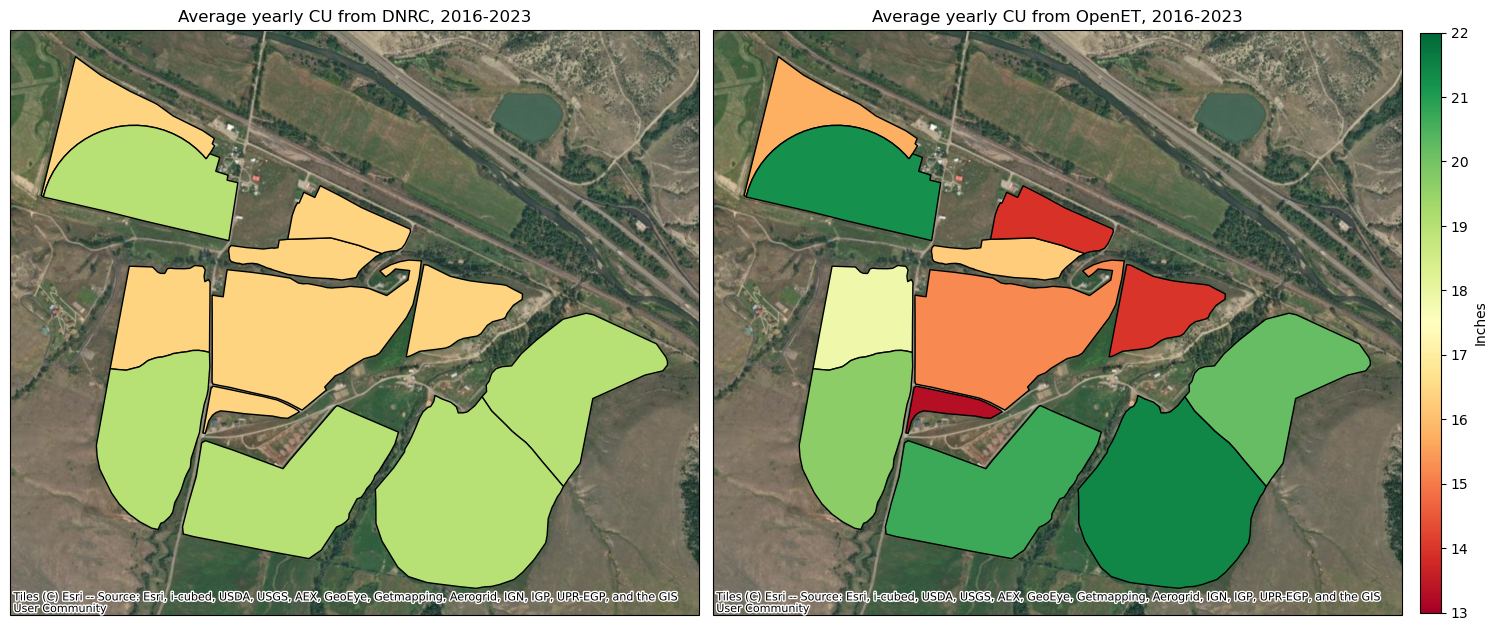

In [18]:
vmin, vmax = 13, 22

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2, figsize=(14, 10), subplot_kw={'projection': ccrs.epsg(5071)}, layout='constrained')

# divider = make_axes_locatable(ax[0])
# cax = divider.append_axes("right", size="5%", pad=0.1)

fields.plot(ax=ax[0], column='dnrc_cu', edgecolor='black', cmap='RdYlGn', transform=ccrs.epsg(5071), vmin=vmin, vmax=vmax)
ctx.add_basemap(ax[0], source=ctx.providers.Esri.WorldImagery, crs=ccrs.epsg(5071))
ax[0].set_title('Average yearly CU from DNRC, 2016-2023')

fig = ax[1].get_figure()
# cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
# cax = fig.add_axes([1.01, 0.25, 0.015, 0.5])
cax = fig.add_axes([1.01, 0.21, 0.015, 1-2*(0.21)])
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, label='Inches')

fields.plot(ax=ax[1], column='opnt_cu', edgecolor='black', cmap='RdYlGn', transform=ccrs.epsg(5071), vmin=vmin, vmax=vmax)
ctx.add_basemap(ax[1], source=ctx.providers.Esri.WorldImagery, crs=ccrs.epsg(5071))
ax[1].set_title('Average yearly CU from OpenET, 2016-2023')

plt.show()

Note the greater variability in the OpenET results (right). The only reason for two different values in the DNRC results (left) is the distinction between flood or pivot irrigation.